In [47]:
import duckdb

conn = duckdb.connect("data/data.db")

query = """
select
    f.video_frame_index,
    f.timestamp_ms,
    d.id,
    r.cluster_id,
    d.osnet_embedding,
    d.clip_embedding,
from intravideo_object_ids r
left join detection d on d.id=r.detection_id
left join frame f on f.id=d.frame_id
left join video v on v.id=f.video_id
where
    v.filepath ilike '%video_2%'
    and not r.is_bad_frame
"""

df = conn.sql(query).df()
df.head()

,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding
0,0,0.0,7d842122-1181-4e85-b15b-49a52f628602,0,"[0.033175, 0.119434826, 0.0, 0.0, 0.03312999, ...","[0.056604043, 0.039600655, 0.0013745289, 0.008..."
1,1,41.0,3da0b007-c7c3-4401-85ee-8102a7dc97db,0,"[0.015835963, 0.117593095, 0.0, 0.0, 0.0166084...","[0.052786738, 0.050749164, 0.004398974, 0.0072..."
2,2,83.0,7314c341-b42e-4e54-a872-4111b2dc3fd9,0,"[0.023024628, 0.12468861, 0.0, 0.0, 0.01738269...","[0.04970088, 0.056119885, 0.0071378127, 0.0038..."
3,3,125.0,75e27bd1-0859-4337-a76e-f8c5b13b81d5,0,"[0.01399459, 0.13459277, 0.0, 0.0, 0.02175565,...","[0.050072547, 0.061224256, 0.010126432, 0.0097..."
4,4,166.0,01ac809f-431b-419d-a057-96d53a0bff37,0,"[0.003186742, 0.12631486, 0.0, 0.0, 0.00838739...","[0.04748863, 0.047959454, 0.0063462593, -0.002..."


[4245, 4345, 5673]
[110, 270, 380, 505, 1620, 1815, 1915, 2075, 2665, 2815, 2915, 3085, 3735, 3950, 4125, 4375, 5010, 5200, 5345, 5540, 5673]
4     1115
12     650
16     635
8      590
15     250
13     215
5      195
19     195
17     190
14     175
11     170
7      160
1      160
9      150
18     145
20     133
3      125
0      110
2      110
6      100
10     100
Name: count, dtype: int64


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

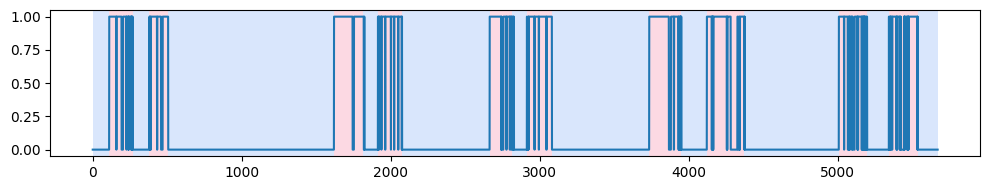

In [48]:
import numpy as np
import ruptures as rpt
import pandas as pd
import plotly.express as px
from scipy.ndimage import binary_opening, binary_closing

max_frame = df['video_frame_index'].max()
min_frame = df['video_frame_index'].min()
n_frames = max_frame + 1

clusters = df['cluster_id'].unique()

cluster_signals = {
    int(cluster_id): np.zeros(n_frames, dtype=np.uint8) for cluster_id in clusters
}

cluster_breakpoints = {}
bucket_labels = {}

for cluster_id, group in df.groupby("cluster_id"):
    cluster_signals[cluster_id][group["video_frame_index"].values] = 1

    signal = cluster_signals[cluster_id]
    
    # smooth flickers in signal signal
    smoothed = binary_closing(signal, structure=np.ones(10))
    smoothed = binary_opening(smoothed, structure=np.ones(10))
    

    algo = rpt.Pelt(model="l2", min_size=100).fit(smoothed)
    breakpoints = algo.predict(pen=20)
    
    min_length = 150
    filtered_cps = [cp for i, cp in enumerate(breakpoints)
                if i == 0 or (cp - breakpoints[i-1]) > min_length]
    cluster_breakpoints[cluster_id] = breakpoints
    print(breakpoints)
    
    labels = np.full_like(signal, fill_value=-1, dtype=np.int8)  # or use None or np.nan if preferred
    bucket = 0
    bp_idx = 0

    prev = 0
    curr = 0
    curr_label = 0
    
    for breakpoint in breakpoints:
        curr = breakpoint
        
        labels[prev:curr] = curr_label
        
        prev = breakpoint
        curr_label += 1
    
    bucket_labels[cluster_id] = labels[labels != -1]

PERSON_ID = 1

print(pd.Series(bucket_labels[PERSON_ID]).value_counts())
rpt.display(cluster_signals[PERSON_ID], cluster_breakpoints[PERSON_ID])

In [49]:
import pandas as pd

person_1 = df[df['cluster_id'] == PERSON_ID]
person_1 = person_1.merge(
    pd.DataFrame({
        "appearance_bucket": bucket_labels[PERSON_ID],
        "signal": cluster_signals[PERSON_ID]
    }),
    how="left",
    left_on="video_frame_index",
    right_index=True
)
# get interarrival times
person_1['iat'] = person_1['timestamp_ms'].diff().fillna(0)

# normalize iat per bucket
person_1['iat_norm'] = person_1.groupby('appearance_bucket')['iat'].transform(
    lambda x: (x + 1e-3) / (x.sum() + 1e-6)
)

person_1 = person_1.groupby('appearance_bucket').filter(lambda g: g['signal'].sum() > 10)

# sample person_1 to prioritize sparser samples
STRATIFIED_SAMPLE_K = 100

person_1 = (
    person_1
    .sort_values('iat_norm', ascending=False)
    .groupby('appearance_bucket')
    .head(STRATIFIED_SAMPLE_K)
    .sort_values('video_frame_index')
)
person_1.head()

,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding,appearance_bucket,signal,iat,iat_norm
115,113,4708.0,7cdb3159-aa79-4e63-a7af-0ef0d1de5ba4,1,"[0.0, 0.05358624, 0.0, 0.0, 0.0722448, 0.03122...","[0.05547426, 0.02847514, -0.0013191176, 0.0187...",1,1,42.0,0.006462
117,114,4750.0,a1889b16-077a-44b8-94c4-d3104d4ba509,1,"[0.0, 0.027213242, 0.0, 0.0, 0.10664623, 0.018...","[0.07814356, 0.008628164, 0.0012642494, 0.0413...",1,1,42.0,0.006462
119,115,4791.0,c5d33f2e-57f4-4ec0-b611-b41228f57776,1,"[0.04517466, 0.08366621, 0.0, 0.0, 0.113980964...","[0.071573, 0.028872084, -0.0022605972, 0.01895...",1,1,41.0,0.006308
120,116,4833.0,82375cb1-152c-4ca7-8dca-380964bf18a4,1,"[0.039278768, 0.058360603, 0.0, 0.0, 0.0889055...","[0.07776484, 0.02870843, -0.0014108137, 0.0230...",1,1,42.0,0.006462
122,117,4875.0,9ad6d722-836f-42b8-bf8a-12d9ce29f38c,1,"[0.04314286, 0.04798399, 0.0, 0.0, 0.0697395, ...","[0.065428816, 0.01620725, 0.0009499808, 0.0127...",1,1,42.0,0.006462


In [50]:
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

# higher energy = more change
# this is like a non-parametric version of KL divergence
# we could also do a gaussian KDE and then measure residuals but this requires no
# model training >:)

def energy_distance_cosine(X: np.ndarray, Y: np.ndarray):
    N, M = len(X), len(Y)
    cross = np.sum(cdist(X, Y, metric="cosine")) / (N * M)
    xx = np.sum(cdist(X, X, metric="cosine")) / (N * N)
    yy = np.sum(cdist(Y, Y, metric='cosine')) / (M * M)
    return 2 * cross - xx - yy

person_1['clip_pca_50'] = PCA(n_components=50).fit_transform(person_1['clip_embedding'].to_list()).tolist()

appearance_buckets = []
appearance_matrices = []
distances = [0]

for appearance_bucket, dff in person_1.groupby('appearance_bucket'):
    appearance_buckets.append(appearance_bucket)
    appearance_matrices.append(np.stack(dff['clip_pca_50'].to_list()))

for i in range(1, len(appearance_buckets)):
    curr = appearance_matrices[i]
    prev = appearance_matrices[i-1]
    distances.append(energy_distance_cosine(curr, prev))

print([i.size for i in appearance_matrices])
print(len(appearance_buckets), len(distances))
print([float(round(i, 3)) for i in distances])

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
10 10
[0.0, 0.118, 0.133, 0.166, 0.797, 0.348, 0.486, 0.284, 0.645, 0.465]


/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/besaleli/reid_mvp/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normaliz

In [51]:
THRESHOLD = 0.48

anomalies = {b: bool(distance > THRESHOLD) for b, distance in zip(appearance_buckets, distances)}
person_1['is_anomaly'] = person_1['appearance_bucket'].map(anomalies)
print(anomalies)
person_1.head()

{1: False, 3: False, 5: False, 7: False, 9: True, 11: False, 13: True, 15: False, 17: True, 19: False}


,video_frame_index,timestamp_ms,id,cluster_id,osnet_embedding,clip_embedding,appearance_bucket,signal,iat,iat_norm,clip_pca_50,is_anomaly
115,113,4708.0,7cdb3159-aa79-4e63-a7af-0ef0d1de5ba4,1,"[0.0, 0.05358624, 0.0, 0.0, 0.0722448, 0.03122...","[0.05547426, 0.02847514, -0.0013191176, 0.0187...",1,1,42.0,0.006462,"[-0.07901428102920681, -0.16278696209213991, 0...",False
117,114,4750.0,a1889b16-077a-44b8-94c4-d3104d4ba509,1,"[0.0, 0.027213242, 0.0, 0.0, 0.10664623, 0.018...","[0.07814356, 0.008628164, 0.0012642494, 0.0413...",1,1,42.0,0.006462,"[-0.050232901971099184, -0.21064600712910095, ...",False
119,115,4791.0,c5d33f2e-57f4-4ec0-b611-b41228f57776,1,"[0.04517466, 0.08366621, 0.0, 0.0, 0.113980964...","[0.071573, 0.028872084, -0.0022605972, 0.01895...",1,1,41.0,0.006308,"[-0.11282168013208578, -0.15240601075479587, 0...",False
120,116,4833.0,82375cb1-152c-4ca7-8dca-380964bf18a4,1,"[0.039278768, 0.058360603, 0.0, 0.0, 0.0889055...","[0.07776484, 0.02870843, -0.0014108137, 0.0230...",1,1,42.0,0.006462,"[-0.06349433653475721, -0.1792778577086514, 0....",False
122,117,4875.0,9ad6d722-836f-42b8-bf8a-12d9ce29f38c,1,"[0.04314286, 0.04798399, 0.0, 0.0, 0.0697395, ...","[0.065428816, 0.01620725, 0.0009499808, 0.0127...",1,1,42.0,0.006462,"[-0.10507584084730313, -0.11313366506689902, 0...",False


In [52]:
conn.close()